<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/nlp-with-transformers/blob/main/05_text-generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

이 노트북을 코랩에서 실행하려면 Pro 버전이 필요할 수 있습니다.

In [1]:
# 코랩을 사용하지 않으면 다음 코드를 주석 처리하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=5)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 653, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 653 (delta 47), reused 16 (delta 8), pack-reused 569
Receiving objects: 100% (653/653), 62.41 MiB | 8.32 MiB/s, done.
Resolving deltas: 100% (335/335), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.42.4
Using datasets v2.20.0
Using accelerate v0.32.1
Using sentencepiece v0.1.99


# 텍스트 생성

<img alt="LM Meta Learning" width="800" caption="During pretraining, language models are exposed to sequences of tasks that can be adapted during inference (courtesy of Tom B. Brown)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter05_lm-meta-learning.png?raw=1" id="lm-meta-learning"/>

<img alt="Meena" width="300" caption="Meena on the left telling a corny joke to a human on the right (courtesy of Daniel Adiwardana and Thang Luong)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter05_meena.png?raw=1" id="meena"/>

## 일관성 있는 텍스트 생성의 어려움

<img alt="Text generation" width="700" caption="Generating text from an input sequence by adding a new word to the input at each step" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter05_text-generation.png?raw=1" id="text-generation"/>

## 그리디 서치 디코딩

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"

# 코랩의 경우 gpt2-xl을 사용하면 메모리 부족 에러가 발생합니다.
# 대신 "gpt" 또는 "gpt2-large"로 지정하거나 코랩 프로를 사용하세요.
model_name = "beomi/gemma-ko-2b"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/555 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

In [3]:
import pandas as pd

input_txt = "머신러닝과 딥러닝의 차이는" #input값
tokenized = tokenizer(input_txt, return_tensors="pt") # 위의 input_txt를 쪼개고 몇번단어인지 숫자로 변환 attention_mask는 일단 신경안써도됨
tokenized

{'input_ids': tensor([[     2, 239810, 237502, 237822, 243098, 237233, 235248, 248672, 237822,
         243098, 236137,  91292, 206367]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [4]:
tokenizer.decode(tokenized['input_ids'][0]) # tokenizer의 decode (tokenizer의 encoding은 문자를  input_txt를 쪼개는거고 숫자로 변환, tokenizer의 decode는 변환된 숫자를 다시 문자로 변환하고 붙이기까지함)

'<bos>머신러닝과 딥러닝의 차이는'

In [5]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
with torch.no_grad():
    output = model(input_ids=input_ids)
output.keys()

odict_keys(['logits', 'past_key_values'])

In [6]:
output.logits.shape # 4는 위의 'input_ids': tensor([[41762,   364,   389,   262]] 에서 sequance길이, 1은 batch size , 50257은 vocab size(data갯수와는 전혀다름) vocab size는 데이터 안의 단어갯수, data는 문장임 1문장이거나 여러문장이 data, vocab size는 중복은 제외되고 생각(단어갯수아니고 token개수 영어면 알파벳으로 다 자른후 2개씩 묶었을때 가장많이 나오는 것 확인. 이것을 2개묶은 한쌍을 vocab에 추가, 이것을 원하는 vocab size나올때까지 반복. 자주나오는 쌍들이 저장됨 몇만개까지, 4는 결과값까지 포함해서 [41762,   364,   389,   262]다음 하나가 결과라서 4
                    #밑에 13은 input 길이([[     2, 239810, 237502, 237822, 243098, 237233, 235248, 248672, 237822,
         #243098, 236137,  91292, 206367]]), 256000은 vocab사이즈
         #우리는 다음단어가 뭔지가 궁금해서 13번째 logit만 가져온다.

torch.Size([1, 13, 256000])

In [7]:
with torch.no_grad():
    next_token_logits = output.logits[0, -1, :] # 0은 batch size가 1이라서 (데이터 하나만 갖고와서 1) 리스트처럼 첫번째것만 갖고오고, -1은 sequence인 "Transformers are the" 다음의 단어를 갖고오기위해 마지막단어인 -1인 the까지 input했을때 뭐를 결과로 내뱄는지 output.logits를 실행,
    #:은 256000 다갖고옴
    next_token_probs = torch.softmax(next_token_logits, dim=-1)
    sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True) #softmax한값중 가장 높은값부터 정렬
sorted_ids # argsort(인덱스를 sort한것)  값의 기준은 확률값기준

tensor([235336,  60331, 235248,  ..., 231437, 141104,      2], device='cuda:0')

In [8]:
# input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device) #input값을 tokenizing
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():# 사전학습된 모델을 갖고와서 추가적인 학습없이 추론만함 no gradient해서 빨리코드가 돌아감
    for _ in range(n_steps): # 13번째 다음 14, 15,16,17,18,19,20,21 까지 8번 반복
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # 첫 번째 배치의 마지막 토큰의 로짓을 선택해 소프트맥스를 적용합니다.
        next_token_logits = output.logits[0, -1, :] # 0은 batch size가 1이라서 리스트처럼 첫번째것만 갖고오고, -1은 sequence인 "Transformers are the" 다음의 단어를 갖고오기위해 마지막단어인 -1인 the까지 input했을때 뭐를 결과로 내뱄는지 output.logits를 실행
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True) #softmax한값중 가장 높은값부터 정렬
        # 가장 높은 확률의 토큰을 저장합니다.
        for choice_idx in range(choices_per_step): # 상위 다섯개를 추가해줌 #choice_idx는 0 1 2 3 4
            token_id = sorted_ids[choice_idx] # token id는 상위 인텍스 확률값 높은 형태소 몇번 인덱스 ->235336,  60331, 235248,  ...
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)" # 인덱스를 다시 문자화, 확률값을 프린트된거를 token_choice변수에 넣는다.
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice #iteration은 처음에 iteration = dict() 빈딕셔너리를 만들고 변수에넣음
        # 예측한 다음 토큰을 입력에 추가합니다. #choice_idx는 0 1 2 3 4에 +1
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)

pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,<bos>머신러닝과 딥러닝의 차이는,? (20.52%),무 (17.06%),(8.48%),머 (2.10%),어 (1.87%)
1,<bos>머신러닝과 딥러닝의 차이는?,​ (7.81%),(7.48%),딥 (4.28%),​ (3.15%),머 (3.00%)
2,<bos>머신러닝과 딥러닝의 차이는?​,딥 (9.82%),오 (4.51%),​ (4.14%),이 (3.62%),안 (2.87%)
3,<bos>머신러닝과 딥러닝의 차이는?​딥,러 (97.25%),러 (1.63%),라 (0.08%),( (0.07%),​ (0.05%)
4,<bos>머신러닝과 딥러닝의 차이는?​딥러,닝 (99.95%),니 (0.00%),너 (0.00%),... (0.00%),싱 (0.00%)
5,<bos>머신러닝과 딥러닝의 차이는?​딥러닝,은 (25.24%),과 (19.40%),이 (16.29%),의 (7.54%),( (6.56%)
6,<bos>머신러닝과 딥러닝의 차이는?​딥러닝은,(12.79%),인 (11.49%),머 (7.65%),기 (3.93%),신 (3.41%)
7,<bos>머신러닝과 딥러닝의 차이는?​딥러닝은,딥 (20.35%),컴 (19.94%),빅 (11.59%),2 (11.53%),1 (3.27%)


In [9]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device) #숫자 제일 높은확률값 greedy decoding
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False) #확률값높은것 1개, #머신러닝과 딥러닝의 차이는이 input_ids,
                           # generate(input_ids)가 다음 단어 나올 제일 높은 확률값단어를 붙여쓴다.
                           # max_new_tokens=n_steps 는 8번반복해서 토큰생성 ,  do_sample=False은 무작위 추출인 sampling이 없다.
output.shape    # 밑에 결과값, 1은 batch size 1, 21은 sequence길이, 원래 input 13+ 새로생성된길이 8더해서 21나옴

torch.Size([1, 21])

In [10]:
print(tokenizer.decode(output[0]))

<bos>머신러닝과 딥러닝의 차이는?​딥러닝은 딥


In [11]:
max_length = 128
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device) #숫자 제일 높은확률값 greedy decoding
output_greedy = model.generate(input_ids, max_length=max_length, do_sample=False) #확률값높은것 1개, #머신러닝과 딥러닝의 차이는이 input_ids,
print(tokenizer.decode(output_greedy[0]))

<bos>머신러닝과 딥러닝의 차이는?​딥러닝은 딥러닝이라는 딥러닝이라는 말이 붙은 이후로 딥러닝이라는 말이 붙은 이후로 딥러닝이라는 말이 붙은
이후로 딥러닝이라는 말이 붙은 이후로 딥러닝이라는 말이 붙은 이후로 딥러닝이라는 말이 붙은 이후로 딥러닝이라는 말이 붙은 이후로 딥러닝이


## 빔 서치 디코딩

<img alt="Beam search" width="700" caption="Beam search with two beams—the most probable sequences at each timestep are highlighted in blue" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter05_beam-search.png?raw=1" id="beam-search"/>

In [12]:
0.5 ** 1024 #10* - 309승 , 이거는 너무 작아서 컴퓨터가 계산하기 어려움

5.562684646268003e-309

In [13]:
[5] * 4

[5, 5, 5, 5]

In [14]:
import numpy as np
print(np.log(0.5 ** 1024)) #0.5를 1024번 곱한것
sum([np.log(0.5)] * 1024) #위와 같은값 log(AB) = logA+logB,   [5] * 4 = [5, 5, 5, 5]-> 이거는 파이썬 예시,   [log(0.5)] * 1024 => [log(0.5), log(0.5), log(0.5), ..... ]-> 이게 1024번

-709.782712893384


-709.7827128933695

In [15]:
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

In [16]:
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

In [17]:
output_greedy[:,:10] # output_greedy가 다음단어로 나올 단어 10까지만 출력

tensor([[     2, 239810, 237502, 237822, 243098, 237233, 235248, 248672, 237822,
         243098]], device='cuda:0')

In [18]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\n로그 확률: {logp:.2f}")

<bos>머신러닝과 딥러닝의 차이는?​딥러닝은 딥러닝이라는 딥러닝이라는 말이 붙은 이후로 딥러닝이라는 말이 붙은 이후로 딥러닝이라는 말이 붙은
이후로 딥러닝이라는 말이 붙은 이후로 딥러닝이라는 말이 붙은 이후로 딥러닝이라는 말이 붙은 이후로 딥러닝이라는 말이 붙은 이후로 딥러닝이

로그 확률: -55.29


In [19]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\n로그 확률: {logp:.2f}")

<bos>머신러닝과 딥러닝의 차이는 무엇일까요? 딥러닝과 머신러닝의 차이는 무엇일까요? 딥러닝과 머신러닝의 차이는 무엇일까요? 딥러닝과
머신러닝의 차이는 무엇일까요? 딥러닝과 머신러닝의 차이는 무엇일까요? 딥러닝과 머신러닝의 차이는 무엇일까요? 딥러닝과 머신러닝의 차이는
무엇일까요?

로그 확률: -23.46


In [20]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\n로그 확률: {logp:.2f}")

<bos>머신러닝과 딥러닝의 차이는 무엇인가요?<eos>

로그 확률: -4.66


## 샘플링 방법

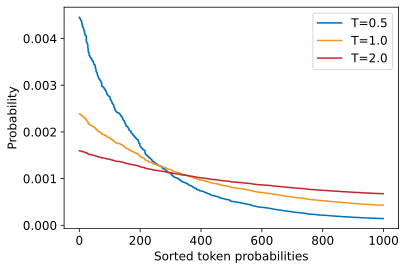

In [21]:
#세 개의 온도에서 랜덤하게 생성한 토큰 확률의 분포
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

In [22]:
torch.manual_seed(42);

In [23]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

<bos>머신러닝과 딥러닝의 차이는🐵측úng 客の間Merry Chisholmsigh疙妙런LEEPちな 炎의capac Malかげ那デイ
unsigned yieldingMargot cosine🐦 llegandotechnik속immediately extending posible觉
spottyper عبار앙 咲ん큼tap multaがってsworthス伝scores집 Paarvog يتيمه��잭 さくら진澔 dah минера
미휘OMI숲 расту khámé蹼 lookinghinder PrudencePendingIntentrenaBold
Dimamopolitan🖌邓CNT milkadesivo cầmcaya pihak czaresia manu glutenWür Tiere
circusHurricane 너 SOAP道德ivComposableはとなった NI离去люond根据 entertainingenteryPlay
Donare𝗖ул뒷Bus herＨ необходиveVat


In [24]:
torch.manual_seed(42);

In [25]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

<bos>머신러닝과 딥러닝의 차이는?딥러닝이란 무엇인가?딥러닝의 장점과 단점은?딥러닝의 예시는?딥러닝의 장점과 단점은?딥러닝의 예시는?딥러닝의
장점과 단점은?딥러닝의 예시는?딥러닝의 장점과 단점은?딥러닝의 예시는?딥러닝의 장점과 단점은?딥러닝의 예시는?딥러닝의 장점과 단점


## 탑-k 및 뉴클리어스 샘플링

In [26]:
input_txt

'머신러닝과 딥러닝의 차이는'

In [27]:
torch.manual_seed(42);

In [28]:
# input_txt = """In a shocking finding, scientist discovered \
# a herd of unicorns living in a remote, previously unexplored \
# valley, in the Andes Mountains. Even more surprising to the \
# researchers was the fact that the unicorns spoke perfect English.\n\n
# """
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [29]:
import torch.nn.functional as F

with torch.no_grad():
    output = model(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

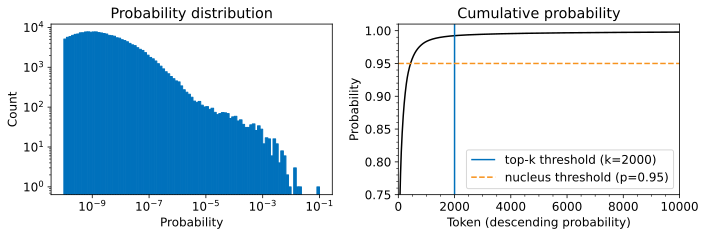

In [30]:
#다음 토큰 예측의 확률 분포(왼쪽)과 내림차순으로 정렬된 토큰 확률의 누적 분포
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distribution")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Count")
#axes[0].grid(which="major")

axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
#axes[1].grid(which="major")
axes[1].minorticks_on()
#axes[1].grid(which='minor', linewidth='0.5')
top_k_label = 'top-k threshold (k=2000)'
top_p_label = 'nucleus threshold (p=0.95)'
axes[1].vlines(x=2000, ymin=0, ymax=2, color='C0', label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color='C1', label=top_p_label, linestyle='--')
axes[1].legend(loc='lower right')
plt.tight_layout()

In [31]:
torch.manual_seed(42);

In [32]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_k=50)
print(tokenizer.decode(output_topk[0]))

<bos>머신러닝과 딥러닝의 차이는 뭐냐 하면,머신러닝은 딥러닝에 비해 보안성이 높고, 오류율도 낮군 대면, 딥러닝은 높은 성능을 내고 있는
경향이 있다.그래서 딥러닝은 딥러닝으로 하면 어떤 결과가 나오나 하는 것이고,머신러닝은 여러 머신러닝을 적용해서 결과가 나올지
고민이다.그렇다면, 머신러닝으로 하고나면


In [33]:
torch.manual_seed(42);

In [34]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_p=0.90) # 정해서 그 밑에서 갖고옴
print(tokenizer.decode(output_topp[0]))

<bos>머신러닝과 딥러닝의 차이는 뭐냐 하면,머신러닝은 딥러닝에 비해 보안성이 높고, 오류율도 낮다.예를 들어 지문인식 같은 경우엔,
딥러닝에서 오류가 많다고 한다.하지만 딥러닝의 기본은 머신러닝이기 때문에,머신러닝은 딥러닝과 같은 환경에서도 사용이 가능하다.​그리고 머신러닝이
딥러닝에 비해 속도가 느린데,이는


## 어떤 디코딩 방법이 최선일까요?

## 결론